## Detailed Model Evaluation

I tried to make a framework for in-depth evaluation of model predictions. I probably made some mistakes, tell me if you see any!

This is mostly just for showcasing/development; what is here is encased in functions in `metric_utils.py`. 

In [32]:
%matplotlib inline
from nl2bash import bashlint
import pandas
import numpy as np
import metric_utils
import matplotlib.pyplot as plt

In [2]:
# reading csv file
result_path = '../../model/seq2seq/bash-T-4-birnn-gru-standard-attention-0.6-0.6-0.0-copy-1.0-128-200-1-0.0001-1e-08-0.6-0.6-0.6-0.6/predictions.beam_search.100.dev.latest.csv'
result_df = pandas.read_csv(result_path)

In [3]:
result_df.head(10) # correct template, correct command are meaningless..

,example_id,description,ground_truth,prediction,correct template,correct command
0,b'0,Adds execution permissions on a script ./etc/b...,chmod +x $(brew --prefix)/etc/bash_completion,NaN,',NaN
1,b',NaN,NaN,find __SP__UNK -type d -exec chmod +x {} \\;,',NaN
2,b',NaN,NaN,find __SP__UNK -type d -exec chmod __SP__UNK {...,',NaN
3,b',NaN,NaN,find __SP__UNK -type d -print0 | xargs -0 -I {...,',NaN
4,b',NaN,NaN,find __SP__UNK -type f -exec chmod +x {} \\;,',NaN
5,b'1,"Add prefix like number and ""^M${LOGFILE}> "" to...","nl -s""^M${LOGFILE}> """,nl -s - -b a -n __SP__UNK,',NaN
6,b',NaN,NaN,nl -s __SP__UNK - | nl,',NaN
7,b',NaN,NaN,nl -s - __SP__UNK | nl -n __SP__UNK,',NaN
8,b',NaN,NaN,nl -s __SP__UNK - | nl -n __SP__UNK,',NaN
9,b',NaN,NaN,nl -s - __SP__UNK | nl -s - __SP__UNK | nl -n ...,',NaN


In [18]:
eval_data = []

for idx, row in result_df.iterrows():
    data_index = row.example_id[2:]
    if len(data_index) != 0:
        eval_data.append(
            metric_utils.EvalDataPoint(int(data_index))
        )
    
    if row[' description'] == row[' description']: # nan detection
        eval_data[-1].description = row[' description']
    
    if row[' ground_truth'] == row[' ground_truth']:
        eval_data[-1].gt_data.append(row[' ground_truth'])
    
    if row[' prediction'] == row[' prediction']:
        eval_data[-1].pred_data.append(row[' prediction'])

In [63]:
# functions from src/evaluate.py
def get_score(prediction_scores):
    score = -1.0
    if len(prediction_scores) == 0:
        return score

    has_positive_score = True in [x > 0 for x in prediction_scores]

    if has_positive_score:
        score = max(prediction_scores)
    else:
        score = sum(prediction_scores) / float(len(prediction_scores))

    return score

def compute_score(ground_truths, predicted_cmds, predicted_confds, metric_params, verbose=False):
    
    prediction_scores = []

    for grnd_truth_cmd in ground_truths:
        for i, predicted_cmd in enumerate(predicted_cmds):
            
            if predicted_cmd is None or len(predicted_cmd) == 0:
                continue
            
            predicted_confidence = predicted_confds[i]
            pair_score = metric_utils.compute_metric(predicted_cmd, predicted_confidence, grnd_truth_cmd, metric_params)
            prediction_scores.append(pair_score)

    score = get_score(prediction_scores)

    if verbose:
        print('-' * 50)
        print(f'Ground truth: {ground_truths}')
        print(f'Predictions: {predicted_cmds}')
        print(f'Prediction scores: {prediction_scores}')
        print(f'Score: {score}')

    return score

In [27]:
# single datapoint showcase
params = {
  "u1": 1.0,
  "u2": 1.0
}

def dp2score(dp, params=params, verbose=False):
    # justa a quality-of-life function
    return compute_score(dp.gt_data, dp.pred_data, [1]*len(dp.pred_data), params, verbose=verbose)

dp2score(eval_data[0], verbose=True)

--------------------------------------------------
Ground truth: ['chmod +x $(brew --prefix)/etc/bash_completion']
Predictions: ['find __SP__UNK -type d -exec chmod +x {} \\\\;', 'find __SP__UNK -type d -exec chmod __SP__UNK {} \\\\;', 'find __SP__UNK -type d -print0 | xargs -0 -I {} chmod +x {}', 'find __SP__UNK -type f -exec chmod +x {} \\\\;']
Score: -1.0


-1.0

In [71]:
# ok, so... we should probably filter out cases where gt marked on gt doesn't get perfect score.

# Example:
dp = eval_data[8]
compute_score(dp.gt_data, dp.gt_data, [1]*len(dp.pred_data), params, verbose=True)

--------------------------------------------------
Ground truth: ['rsync -rvz --chmod=ugo=rwX -e ssh source destination']
Predictions: ['rsync -rvz --chmod=ugo=rwX -e ssh source destination']
Prediction scores: [0.0]
Score: 0.0


0.0

In [70]:
# Filtering:
filter_func = lambda dp: compute_score(dp.gt_data, dp.gt_data, [1]*len(dp.gt_data), params) != 0.
filtered_data = list(filter(filter_func, eval_data))
print('Before filtered:', len(eval_data))
print('After filtered:', len(filtered_data))

Before filtered: 701
After filtered: 505


In [53]:
# calculating scores takes some time actually
all_scores = list(map(dp2score, filtered_data))

In [65]:
# filtering by score showcase
threshold = 0.0
with open(f'BadCases_{threshold}.txt', 'w') as f:
    for score, dp in zip(all_scores, filtered_data):
        if score < threshold:
            print(f'----- ID: {dp.index} -----', file=f)
            print(f'GT(s):', file=f)
            print('\n'.join(dp.gt_data), file=f)
            print(f'Predictions:', file=f)
            print('\n'.join(dp.pred_data), file=f)
            print(f'Score: {score}', file=f)

Total: 505
Average: 0.2654118117764157
Median: 0.5
Number of perfect scores: 187
Number of completely wrong: 59
Positive scores: 332
Sub-zero scores: 166
Number of balanced: 7


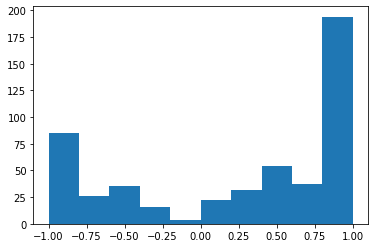

In [68]:
# score distribution showcase

n_by_bin, _, _ = plt.hist(all_scores)

print('Total:', len(all_scores))
print('Average:', np.mean(all_scores))
print('Median:', np.median(all_scores))
print('Number of perfect scores:', len([e for e in all_scores if 1-e<1e-4]))
print('Number of completely wrong:', len([e for e in all_scores if e+1<1e-4]))
print('Positive scores:', len([e for e in all_scores if e > 0]))
print('Sub-zero scores:', len([e for e in all_scores if e < 0]))
print('Number of balanced:', len([e for e in all_scores if abs(e)<1e-4]))

In [40]:
n_by_bin

(array([239.,  39.,  45.,  22.,   4.,  35.,  32.,  54.,  37., 194.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

In [69]:
ast = bashlint.data_tools.bash_parser('comm -23 <(ls) <(ls *Music*)')
bashlint.data_tools.pretty_print(ast)

ROOT()
    UTILITY(comm)
        FLAG(-2)
        FLAG(-3)
        PROCESSSUBSTITUTION(<)
            UTILITY(ls)
        PROCESSSUBSTITUTION(<)
            UTILITY(ls)
                ARGUMENT(*Music*)<File>


In [64]:
compute_score(['sudo chown root:root testfile.txt'], ['chown root:root __SP__UNK'], [1], params, verbose=True)

--------------------------------------------------
Ground truth: ['sudo chown root:root testfile.txt']
Predictions: ['chown root:root __SP__UNK']
Prediction scores: [1.0]
Score: 1.0


1.0